# Examples_SimpleIceModel.py
Explain how to use the Semtner 1976 simple ice model implemented here.

BR, 2023/08/09 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.integrate as scint
import Semtner76_0layer_v1 as sem

In [2]:
T_day = 86400 # Number of seconds in one day
ny = 5 # Number of years to run
tf = T_day * 365 * ny# length of run
# Initial value
H0, T0 = 1.1, -20
# Need to give the time array
time_int = np.arange(0,int(tf/T_day)+1)
da_ones = xr.DataArray(data=np.ones_like(time_int),coords={'time':pd.to_datetime(time_int,unit='D')},dims='time')

In [3]:
def createSeasonalCycle(minVal=0,maxVal=500,L_sumr=30*5,DoY_Pk=183,bw_smooth=30):
    """Generate a smoothed climatology for dummy heat flux: 
    Flat minimum value in winter, triangular peak in summer, smoothed by rolling mean.
    Default values are for solar radiation
    Inputs: -minVal: winter, minimum value (default= 0 W m-2)
            -maxVal: summer peak, maximum value (default= 500 W m-2, smoothing brings it down)
            -L_sumr: length of the summer season (default= 30*5 days = 5 months)
            -Doy_Pk: Day of year for the summer peak (default= 183, corresponding to Jun 21st)
            -bw_smooth: bandwidth for lowpass filter smoothing (default= 30 days) 
    Outputs: DataArray, seasonal cycle.
    """
    F_heat = pd.DataFrame(minVal * np.ones(366),index=np.arange(1,367))
    Time_doy = xr.DataArray(np.arange(1,367),dims='dayofyear')
    # Calculate the slope:
    Inc_F_heat = (maxVal-minVal)/(L_sumr/2)
    # Loop over the length of the summer
    for dd in range(0,L_sumr):
        # If 1st half of summer
        if dd < L_sumr/2:
            F_heat.loc[int(DoY_Pk - np.ceil(L_sumr/2) + dd)] = minVal + Inc_F_heat * dd
        # If 1st half of summer
        if dd >= L_sumr/2:
            F_heat.loc[int(DoY_Pk - np.ceil(L_sumr/2) + dd)] = maxVal - Inc_F_heat * (dd - L_sumr/2)
    # Now smooth it all to have a nicer shape
    F_heat_smooth = pd.DataFrame(F_heat).rolling(bw_smooth,center=True,min_periods=0).mean()
    # Return this climatology in a DataArray, with doy dimension.
    return xr.DataArray(F_heat_smooth.squeeze(),dims={'dayofyear'},coords={'dayofyear':Time_doy})

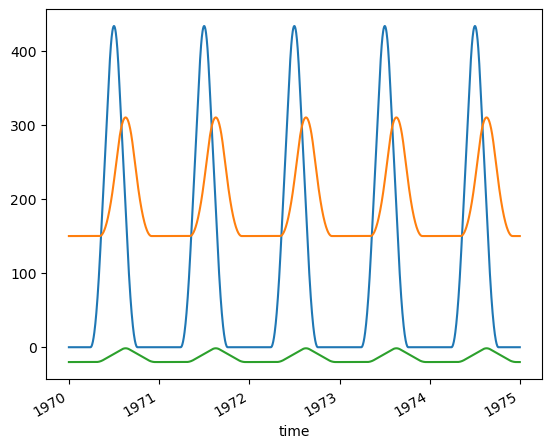

In [5]:
F_sw_clim = createSeasonalCycle(minVal=0,maxVal=500,L_sumr=30*5,DoY_Pk=183,bw_smooth=40)
F_sw = da_ones.groupby('time.dayofyear') * F_sw_clim
F_lw_clim = createSeasonalCycle(minVal=150,maxVal=350,L_sumr=30*5,DoY_Pk=230,bw_smooth=60)
F_lw = da_ones.groupby('time.dayofyear') * F_lw_clim
T_a_clim = createSeasonalCycle(minVal=-20,maxVal=0,L_sumr=30*7,DoY_Pk=230,bw_smooth=30)
T_a = da_ones.groupby('time.dayofyear') * T_a_clim
F_sw.plot(label='Shortwave')
F_lw.plot(label='Longtwave')
T_a.plot(label='Air Temperature')

In [6]:
param = dict()
param['q'] = 300*1e6 # Latent heat capcity, [J/m3]
param['k_i'] = 2.3 # Heat conductivity, [J/m/K/s]
param['albedo_ice'] = 0.8 # Bare ice albedo, [-]
param['albedo_melt'] = 0.5 # Melt ice albedo, [-]
# Forcing-related constant parameters
param['T_w_in'] = -1.75 # Ice bottom temperature, often assumed constant at the melting point [°C]
param['time_in'] = time_int # Time vector of input forcing (like np.arange(0,int(tf/T_day)+1)) [day]
# Forcings
param['F_wind10_in'] = 6. # Wind speed for sensible heat flux (list, same size as time_int) [m/s]
param['F_w_in'] = 4. * np.ones(time_int.size) # Bottom ice-ocean heat flux, positive upward. (list, same size as time_int) [W/m2]
param['F_lw_in'] = F_lw.values # Incoming (downward) longwave (thermal) radiation (list, same size as time_int) [W/m2] 
param['F_sw_in'] = F_sw.values # Incoming (downward) shortwave (solar) radiation  (list, same size as time_int) [W/m2]
param['T_a_in'] = T_a.values # Air temperature at 2m (list, same size as time_int) [°C]
param['F_lh_in'] = T_a.values# * np.ones(time_int.size) # Downward latent heat flux due to sublimation or condensation 

In [7]:
# Copy the default parameter dictionary
param_ctrl = param.copy()
# Use the solver
sol_ctrl = scint.solve_ivp(sem.Semtner76model_0layiceH,
                           (0, tf),#-T_day),
                           [H0,T0,0],
                           method='Radau',
                           args=(param_ctrl,), 
                           t_eval=np.arange(0, tf+1, 86400),
                           max_step=T_day/3)
# Convert to a nice Dataset
ds_sol_ctrl=sem.convert2ds(sol_ctrl,params=param_ctrl)

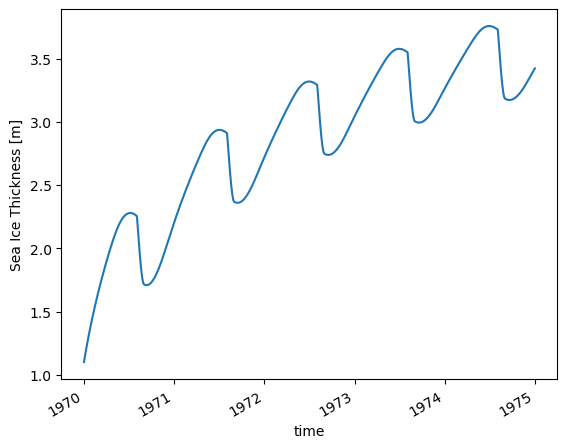

In [8]:
ds_sol_ctrl.H_i.plot()